In [1]:
import mpmath as mp
from mpmath import *

# Plus basses sont les valeurs de phi0 qu'on veut explorer, plus haut on met dps, et plus on fine tune alpha_max
mp.dps = 500
mp.prec = 166

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

lnMpinGev = mp.mpf('42.334')
Mp = mp.exp(lnMpinGev)
Pstar = mp.mpf('2.10310517e-9')


def norm_potential(x,alpha,phi0):
    return x**mp.mpf('2')-mp.mpf('2')/3*alpha*x**6+alpha/mp.mpf('5')*x**10

def norm_eps1(x,alpha,phi0):
    return mp.mpf('450')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**4))**2/((phi0*x)**mp.mpf('2')*(mp.mpf('15')+alpha*x**4*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)

def norm_eps2(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('15')+alpha*x**mp.mpf('4')*(mp.mpf('40')+x**mp.mpf('4')*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/(phi0**2*x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)

def norm_eps3(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**mp.mpf('4')))*(mp.mpf('225')+alpha*x**mp.mpf('4')*(-mp.mpf('1350')+x**4*(mp.mpf('3915')+alpha*(-mp.mpf('2100')+mp.mpf('20')*(mp.mpf('81')-mp.mpf('10')*alpha)*x**4+mp.mpf('15')*(-mp.mpf('99')+mp.mpf('20')*alpha)*x**mp.mpf('8')+mp.mpf('90')*alpha*x**mp.mpf('12')+mp.mpf('9')*alpha*x**16)))))/(x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2*(mp.mpf('15')+alpha*x**4*(mp.mpf('40')+x**4*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/phi0**2

def x_endinf(alpha,phi0):
    xstart = mp.mpf('0.9841521')
    return mp.findroot(lambda x : norm_eps1(x,alpha,phi0)-mp.mpf('1'), xstart,solver='halley', verbose = False)

def efold_primitive(x,alpha,phi0):
    aplus=-alpha+mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    aminus=-alpha-mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    bplus=mp.mpf('2')*(aplus+alpha/mp.mpf('3'))/(aplus-aminus)
    bminus=mp.mpf('2')*(aminus+alpha/mp.mpf('3'))/(aminus-aplus)
    return phi0**2*(mp.re(x**2/20+bplus/(10*mp.sqrt(aplus))*mp.atan(mp.sqrt(aplus)*x**2)+bminus/(10*mp.sqrt(aminus))*mp.atan(mp.sqrt(aminus)*x**2)))

def get_calfconst_rrad(lnRrad,Pstar,epsEnd,potEnd):
    cmbMeasuredQuart = mp.mpf('0.25')*mp.log(Pstar*mp.mpf('8')*mp.pi**2)
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = mp.log(kstar) - lnMpcToKappa - mp.mpf('0.5')*mp.log(HubbleSquareRootOf3OmegaRad) - mp.mpf('0.25')*mp.log(RelatDofRatio)
    return - N0 + cmbMeasuredQuart-mp.mpf('0.25')*mp.log(potEnd/(mp.mpf('3')-epsEnd)) + lnRrad

def x_rrad(alpha,phi0,lnRrad,Pstar):
    xEnd = x_endinf(alpha,phi0)
    epsOneEnd = norm_eps1(xEnd,alpha,phi0)
    potEnd = norm_potential(xEnd,alpha,phi0)
    primEnd = efold_primitive(xEnd,alpha,phi0)
    calF = get_calfconst_rrad(lnRrad,Pstar,epsOneEnd,potEnd)
    calFplusNuEnd = calF+primEnd
    x_eps10 = 1
    return mp.findroot(lambda x : find_x_rrad(x, alpha, phi0,calFplusNuEnd), mp.mpf('1'), solver='halley', verbose = False)

def find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar):
    return nuStar - calFplusNuEnd + mp.mpf('0.25')*mp.log(mp.mpf('9')/(epsOneStar*Vstar))

def find_x_rrad(x,alpha,phi0,calFplusNuEnd):
    nuStar = efold_primitive(x,alpha,phi0)
    epsOneStar = norm_eps1(x,alpha,phi0)
    Vstar = norm_potential(x,alpha,phi0)
    res = find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar)
    return res

def ns_r_plan(phi0, alpha, lnRrad):
    xstar = x_rrad(alpha, phi0/Mp, lnRrad, Pstar)
    eps1star = norm_eps1(xstar,alpha,phi0/Mp)
    eps2star = norm_eps2(xstar,alpha,phi0/Mp)
    eps3star = norm_eps3(xstar,alpha,phi0/Mp)
    ns = 1-2*eps1star-eps2star
    r = 16*eps1star
    alpha_s = -2*eps1star*eps2star-eps2star*eps3star
    return float(ns), float(r), float(alpha_s)

delta_alpha2 = [mp.mpf('8e-30')*(mp.mpf('1.92e-8')/mp.mpf('8e-30'))**(i/mp.mpf('50')) for i in range(50)]

def generate_examples(phi0_start, alpha_start, delta_alpha):
    L = []
    for i in range(-40,60):
        print('.',end="", flush=True)
        alpha = alpha_start+i*delta_alpha
        L.append([*ns_r_plan(phi0_start, alpha, 0), float(mp.log10(mp.fabs(1-alpha)))])
    return L

phi0_start2 = np.array([mp.mpf(phi0) for phi0 in np.array(pd.read_csv('tree09665Inst.csv', dtype = str, index_col=0)['phi0B'])][::2][:-1])
alpha_start2 = np.array([mp.mpf(phi0) for phi0 in np.array(pd.read_csv('tree09665Inst.csv', dtype = str, index_col=0)['alpha'])][::2][:-1])

example_tot2 = []
for i in range(50):
    example_i = generate_examples(phi0_start2[i], alpha_start2[i], delta_alpha2[i])
    example_tot2 = example_tot2+example_i
    print(' '+str(i+1)+'/50')
example_tot2 = np.transpose(example_tot2)


.................................................................................................... 1/50
.................................................................................................... 2/50
.................................................................................................... 3/50
.................................................................................................... 4/50
.................................................................................................... 5/50
.................................................................................................... 6/50
.................................................................................................... 7/50
.................................................................................................... 8/50
.................................................................................................... 9/50
..............................................

plikHM_TTTEEE_lowl_lowE_BK15_lensing\base_nrun_r_plikHM_TTTEEE_lowl_lowE_BK15_lensing_1.txt
plikHM_TTTEEE_lowl_lowE_BK15_lensing\base_nrun_r_plikHM_TTTEEE_lowl_lowE_BK15_lensing_2.txt
plikHM_TTTEEE_lowl_lowE_BK15_lensing\base_nrun_r_plikHM_TTTEEE_lowl_lowE_BK15_lensing_3.txt
plikHM_TTTEEE_lowl_lowE_BK15_lensing\base_nrun_r_plikHM_TTTEEE_lowl_lowE_BK15_lensing_4.txt
Removed no burn in


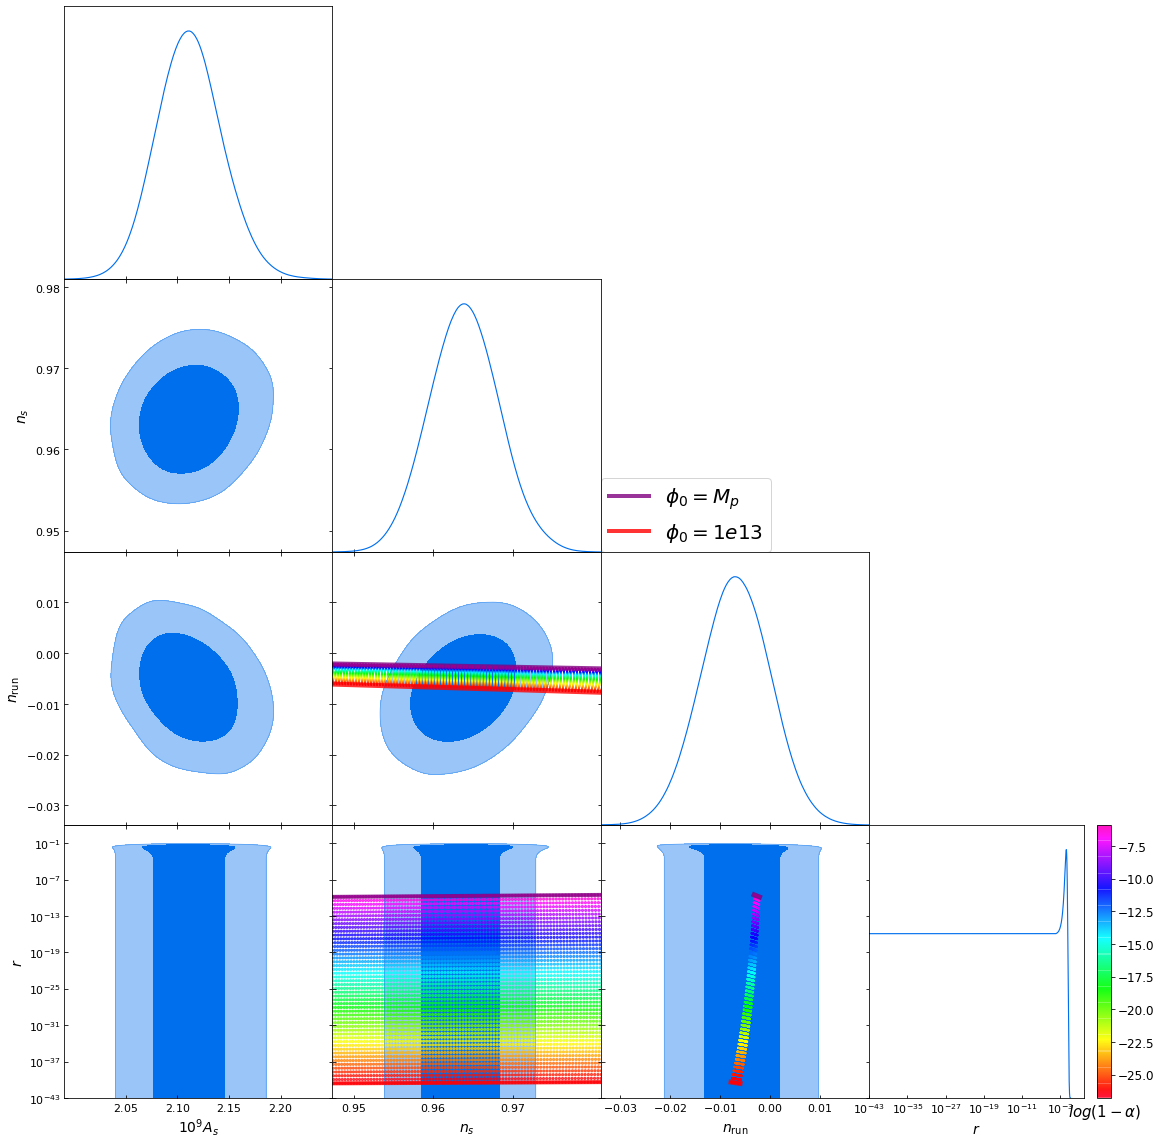

In [2]:
s = loadMCSamples('plikHM_TTTEEE_lowl_lowE_BK15_lensing/base_nrun_r_plikHM_TTTEEE_lowl_lowE_BK15_lensing')

plot1 = gdplt.get_subplot_plotter(subplot_size=4)
# plot1.triangle_plot(s, ['A','ns', 'nrun'], filled = True)
plot1.triangle_plot(s, ['A','ns', 'nrun', 'r'], filled = True)
nsr = plot1.subplots[3,1]
plot1.subplots[3,3].semilogx()
nsr.semilogy()
nsr.axis(ymin=10**-43,ymax=100)
tac = nsr.scatter(example_tot2[0], example_tot2[1], c=example_tot2[3], cmap = 'gist_rainbow',  s=5, alpha = 0.7)

nsr.plot([example_tot2[0][-1], example_tot2[0][-100]],[example_tot2[1][-1],example_tot2[1][-100]],label=r'$\phi_0=M_p$', color = 'purple', lw=4, alpha = 0.8)
nsr.plot([example_tot2[0][0], example_tot2[0][99]],[example_tot2[1][0],example_tot2[1][99]],label=r'$\phi_0=1e13$', color = 'red', lw=4, alpha = 0.8)

plot1.subplots[2,1].scatter(example_tot2[0], example_tot2[2], c=example_tot2[3], cmap = 'gist_rainbow', s=1)
plot1.subplots[2,1].plot([example_tot2[0][-1], example_tot2[0][-100]],[example_tot2[2][-1],example_tot2[2][-100]],label=r'$\phi_0=M_p$', color = 'purple', lw=5, alpha = 0.8)
plot1.subplots[2,1].plot([example_tot2[0][0], example_tot2[0][99]],[example_tot2[2][0],example_tot2[2][99]],label=r'$\phi_0=1e13$', color = 'red', lw=5, alpha = 0.8)

plot1.subplots[3,2].scatter(example_tot2[2], example_tot2[1], c=example_tot2[3], cmap = 'gist_rainbow', s=1)
plot1.subplots[3,2].plot([example_tot2[2][-1], example_tot2[2][-100]],[example_tot2[1][-1],example_tot2[1][-100]],label=r'$\phi_0=M_p$', color = 'purple', lw=5, alpha = 0.8)
plot1.subplots[3,2].plot([example_tot2[2][0], example_tot2[2][99]],[example_tot2[1][0],example_tot2[1][99]],label=r'$\phi_0=1e13$', color = 'red', lw=5, alpha = 0.8)

plot1.subplots[1,0].scatter([2.203e-9]*len(example_tot2[0]), example_tot2[0], c=example_tot2[3], cmap = 'gist_rainbow', s=1)
plot1.subplots[2,0].scatter([2.203e-9]*len(example_tot2[0]), example_tot2[2], c=example_tot2[3], cmap = 'gist_rainbow', s=1)
plot1.subplots[3,0].scatter([2.203e-9]*len(example_tot2[0]), example_tot2[1], c=example_tot2[3], cmap = 'gist_rainbow', s=1)

bar = plt.colorbar(tac)
bar.ax.tick_params(labelsize=12) 
bar.ax.set_xlabel(r'$log(1-\alpha)$',fontsize=15, family='serif')
nsr.legend(fontsize=20, loc=(1,2))

# plt.figure()
# plt.scatter([2.203e-9]*len(example_tot2[0]), example_tot2[0], c=example_tot2[3], cmap = 'gist_rainbow', s=1)

# plot.fig.savefig('test.png')
